In [1]:
import os
import numpy as np
import mdtraj as md
import pickle
from simtk.openmm import unit
from tqdm import tqdm_notebook
from simtk.openmm import app
import matplotlib.pyplot as plt
from openeye import oechem


In [2]:
def make_traj(phase, out_dir, sub_dir, htf, state=None, replica_id=None, n_iterations_start=None, n_iterations_end=None):
    """
    Retrieve pdbs/dcds of the old and new positions for a given thermodynamic state index or replica id. 
    
    Adapted from Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    
    Parameters
    ----------
    phase : str
        phase of simulation (e.g., 'complex')
    out_dir : str
        path to directory containing data to analyze
    sub_dir : str
        path to sub-directory containing data to analyze
    htf : perses.annihilation.relative.RESTCapableHybridTopologyFactory
        hybrid topology factory containing hybrid topology, positions, system
    state : int, default None
        state index
    replica_id : int, default None
        replica id
    n_iterations_start : int, default None
        iteration to start the trajectory
    n_iterations_end : int, default None
        iteration to end the trajectory
        
    """

    from simtk.openmm import unit, app
    from tqdm import tqdm_notebook

    import os
    import pickle
    import mdtraj as md
    import numpy as np
    
    # Create mdtraj topologies that correspond to the positions we want to create trajectories for
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    
    # Load nc files
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{sub_dir}_{phase}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{sub_dir}_{phase}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    box_vectors = np.array(nc_checkpoint['box_vectors'])
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    n_iterations_start = 0 if n_iterations_start is None else int(n_iterations_start / checkpoint_interval) + 1
    n_iterations_end = n_iter if n_iterations_end is None else int(n_iterations_end / checkpoint_interval) + 1
    n_iterations = n_iterations_end - n_iterations_start
    print(n_iterations_start, n_iterations_end)
    
    # Retrieve positions 
    all_pos_new = np.zeros(shape=(n_iterations, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iterations, old_top.n_atoms, 3))
    all_box_vectors = np.zeros(shape=(n_iterations, 3, 3), dtype=np.float32)
    for iteration in tqdm_notebook(range(n_iterations_start, n_iterations_end)):
        if state is not None:
            replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == state)[0][0]
        print(replica_id)
        pos = all_positions[iteration,replica_id,:,:] *unit.nanometers
        all_pos_new[iteration-n_iterations_start] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system)
        all_pos_old[iteration-n_iterations_start] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)
        all_box_vectors[iteration-n_iterations_start] = box_vectors[iteration,replica_id,:,:]
    
    # Create trajectories
    traj_old = md.Trajectory(all_pos_old, old_top)
    traj_new = md.Trajectory(all_pos_new, new_top)
    
    # Set unit cell vectors in traj 
    traj_old.unitcell_vectors = all_box_vectors
    traj_new.unitcell_vectors = all_box_vectors
    
    # Save old trajectory
    print("saving old traj")
    traj_old.save(os.path.join(out_dir, f"{sub_dir}_{phase}_old_state_{state}_{n_iterations_start}_{n_iterations_end}_no_imaging.dcd"))
    traj_old[0].save(os.path.join(out_dir, f"{sub_dir}_{phase}_old_state_{state}_{n_iterations_start}_{n_iterations_end}_no_imaging.pdb"))
    
    # Save new trajectory
    print("saving new traj")
    traj_new.save(os.path.join(out_dir, f"{sub_dir}_{phase}_new_state_{state}_{n_iterations_start}_{n_iterations_end}_no_imaging.dcd"))
    traj_new[0].save(os.path.join(out_dir, f"{sub_dir}_{phase}_new_state_{state}_{n_iterations_start}_{n_iterations_end}_no_imaging.pdb"))

# A29Y complex

### Make the trajectory at lambda = 1 endstate new positions

In [2]:
out_dir = "/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/47/15/replicate_1/"
sub_dir = 15
phase = 'complex'


In [3]:
with open(os.path.join(out_dir, f"{sub_dir}_{phase}.pickle"), "rb") as f:
    htf = pickle.load(f)
    

In [7]:
# Generate 50 ns trajectory at lambda = 1 state
make_traj(phase, out_dir, sub_dir, htf, state=23, n_iterations_end=50001)


0 501


/scratch/lsftmp/13871521.tmpdir/ipykernel_16171/223643861.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iteration in tqdm_notebook(range(n_iterations_start, n_iterations_end)):


  0%|          | 0/501 [00:00<?, ?it/s]

23
14
16
15
9
20
14
14
20
0
16
16
16
9
5
16
20
0
0
23
15
17
20
6
4
12
12
9
13
11
3
17
3
0
9
17
12
3
5
3
9
3
3
16
9
17
12
14
22
7
3
6
16
17
11
3
16
16
4
20
12
3
9
20
5
11
4
8
9
5
17
20
16
6
1
20
7
7
9
4
8
7
4
0
3
20
15
12
3
3
12
4
7
6
23
1
3
20
20
19
15
7
20
17
19
22
5
5
5
3
18
23
23
20
19
12
5
0
22
14
20
17
17
1
16
13
9
12
0
8
12
6
8
6
16
23
5
16
19
11
16
5
6
16
2
13
7
23
5
16
16
14
21
8
2
5
7
2
17
7
14
23
5
11
6
5
12
11
6
20
13
20
0
0
6
17
5
6
9
9
5
1
5
14
14
17
17
14
3
6
20
14
3
13
5
14
13
5
14
2
14
17
10
8
6
6
20
14
13
8
9
7
6
20
15
14
16
5
17
9
15
11
15
1
10
10
15
23
7
10
15
5
15
14
15
7
5
15
20
9
14
15
15
13
4
13
12
5
15
15
15
5
7
7
13
19
2
2
14
12
7
9
15
3
10
5
7
7
21
14
10
6
6
11
6
0
7
17
10
10
10
7
6
16
17
7
7
17
12
2
0
2
3
16
2
15
2
8
2
3
3
11
11
3
16
20
0
9
16
18
4
11
13
13
16
12
3
7
7
16
7
3
23
5
16
0
3
5
11
7
21
7
3
7
6
8
17
6
12
17
23
23
5
23
6
6
14
3
3
23
1
23
5
9
17
1
6
6
11
3
9
19
6
6
19
19
15
14
19
5
19
19
5
14
3
11
5
10
10
11
19
17
14
18
14
19
16
15
19
3
15
19
16
19
1

In [4]:
# Load traj at lambda = 1 endstate
out_dir = "/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/47/15/replicate_1/"
sub_dir = 15
phase = 'complex'
state = 23
n_iterations_start = 0
n_iterations_end = 501

pdb_filepath = os.path.join(out_dir, f"{sub_dir}_{phase}_new_state_{state}_{n_iterations_start}_{n_iterations_end}_no_imaging.pdb")
pdb = md.load(pdb_filepath)
traj_filepath = os.path.join(out_dir, f"{sub_dir}_{phase}_new_state_{state}_{n_iterations_start}_{n_iterations_end}_no_imaging.dcd")
traj = md.load(traj_filepath, top=pdb)



In [80]:
traj


<mdtraj.Trajectory with 501 frames, 40664 atoms, 12723 residues, and unitcells at 0x2b28f94727c0>

### Load crystal structure

In [5]:
# Load crystal structure in 
barstar = md.load_pdb("/data/chodera/zhangi/perses_benchmark/perses-barnase-barstar-paper/input_files/1brs_barstar_renumbered.pdb")
barnase = md.load_pdb("/data/chodera/zhangi/perses_benchmark/perses-barnase-barstar-paper/input_files/1brs_barnase_renumbered.pdb")

# Barstar:barnase
bsbn_topology = barstar.topology.join(barnase.topology)
bsbn_positions = np.concatenate((barstar.xyz, barnase.xyz), axis=1)
bsbn = md.Trajectory(xyz=bsbn_positions, topology=bsbn_topology)

# Barnase:barstar
bnbs_topology = barnase.topology.join(barstar.topology)
bnbs_positions = np.concatenate((barnase.xyz, barstar.xyz), axis=1)
bnbs = md.Trajectory(xyz=bnbs_positions, topology=bnbs_topology)


### Compute distances

In [6]:
# Y29-H102 closest sidechain heavy atom distance in lambda endstate = 1 traj
contacts = [(29, 268)] # Y29-H102
distances, residue_pairs = md.compute_contacts(traj, contacts=contacts, scheme='sidechain-heavy')
Y29_H102_distances_traj = distances[:, 0]*10 # convert to angstroms

# Y29-H102 closest sidechain heavy atom distance in crystal structure
contacts = [(29, 268)]
distances, residue_pairs = md.compute_contacts(bsbn, contacts=contacts, scheme='sidechain-heavy')
Y29_H102_distances_bsbn = distances[:, 0]*10 # convert to angstroms


/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/mdtraj/geometry/contact.py:199: UserWarning: selected topology includes at least one glycine residue, which has no heavy atoms in its sidechain. The distances involving glycine residues will be computed using the sidechain hydrogen instead.
  warnings.warn('selected topology includes at least one glycine residue, which has no heavy atoms in its sidechain. The distances involving glycine residues '


In [7]:
# Y29 OH - R83 O, Y29 OH - N84 O distances in lambda endstate = 1 traj
atom_pairs = [(481, 2887), (481, 2911)]
distances = md.compute_distances(traj, atom_pairs=atom_pairs)
Y29_R83_distances_traj = distances[:, 0]*10 # convert to angstroms
Y29_N84_distances_traj = distances[:, 1]*10 # convert to angstroms

# Y29 OH - R83 O, Y29 OH - N84 O distances in crystal structure
atom_pairs = [(477, 2887), (477, 2911)]
distances = md.compute_distances(bsbn, atom_pairs=atom_pairs)
Y29_R83_distances_bsbn = distances[:, 0]*10 # convert to angstroms
Y29_N84_distances_bsbn = distances[:, 1]*10 # convert to angstroms


### Plot

In [3]:
filepath_parts = out_dir.split("/")
main_dir = filepath_parts[-4]
sub_dir =filepath_parts[-3]
replicate = filepath_parts[-2][-1]

In [11]:
# Format data and save as pickle
distances_traj_all = [Y29_H102_distances_traj, Y29_R83_distances_traj, Y29_N84_distances_traj]
distances_bsbn_all = [Y29_H102_distances_bsbn, Y29_R83_distances_bsbn, Y29_N84_distances_bsbn]
with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_distances_traj_data.pickle", "wb") as f:
    pickle.dump(distances_traj_all, f)
with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_distances_bsbn_data.pickle", "wb") as f:
    pickle.dump(distances_bsbn_all, f)  


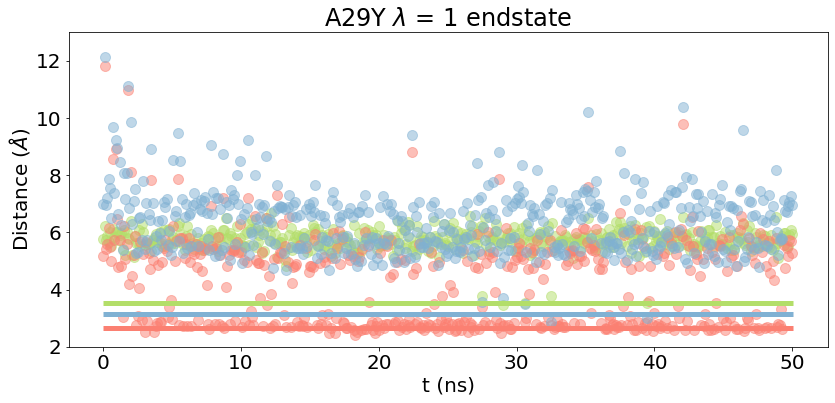

<Figure size 432x288 with 0 Axes>

In [5]:
# Load data
with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_distances_traj_data.pickle", "rb") as f:
    distances_traj_all = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_distances_bsbn_data.pickle", "rb") as f:
    distances_bsbn_all =  pickle.load(f)     

# Create figure
fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(12, 6))

# Set font size
plt.rc('font', size=20) 


# Plot
residue_pair_labels = ["Y29-H102", "Y29-R83", "Y29-N84"]
colors = ["#b3de69", "#fb8072", "#80b1d3"]
for distances_traj, distances_bsbn, residue_pair_label, color in zip(distances_traj_all, distances_bsbn_all, residue_pair_labels, colors):
    plt.scatter(np.arange(len(distances_traj))*100/1000, distances_traj, color=color, s=100, alpha=0.5, label=f"{residue_pair_label} trajectory")
    
for distances_traj, distances_bsbn, residue_pair_label, color in zip(distances_traj_all, distances_bsbn_all, residue_pair_labels, colors):
    plt.hlines(distances_bsbn[0], 0, len(distances_traj)*100/1000, color=color, linewidth=5, label=f"{residue_pair_label} crystal structure")

# Add axis labels    
plt.xlabel("t (ns)")
plt.ylabel("Distance ($\AA$)")

# Add legend
# plt.legend()
    
# Set ylim
plt.ylim([2, 13])
    
# Add title
plt.title(f"A29Y $\lambda$ = 1 endstate")

# Ensure x-axis labels are not cut off
plt.tight_layout()

# Save figure
plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_residue_distances.pdf", dpi=500)

plt.show()
plt.clf()


In [16]:
print(Y29_H102_distances_traj[-1])
print(Y29_R83_distances_traj[-1])
print(Y29_N84_distances_traj[-1])

5.936808
5.2781
6.9480796


In [17]:
print(Y29_H102_distances_bsbn[-1])
print(Y29_R83_distances_bsbn[-1])
print(Y29_N84_distances_bsbn[-1])

3.5477667
2.6523771
3.1302285


# Y29A complex

### Make the trajectory at lambda = 1 endstate new positions

In [6]:
out_dir = "/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/47/1/replicate_1/"
sub_dir = 1
phase = 'complex'


In [15]:
with open(os.path.join(out_dir, f"{sub_dir}_{phase}.pickle"), "rb") as f:
    htf = pickle.load(f)
    

In [23]:
# Generate 50 ns trajectory at lambda = 0 state
make_traj(phase, out_dir, sub_dir, htf, state=0, n_iterations_end=50001)


0 501


/scratch/lsftmp/13916996.tmpdir/ipykernel_322670/223643861.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iteration in tqdm_notebook(range(n_iterations_start, n_iterations_end)):


  0%|          | 0/501 [00:00<?, ?it/s]

0
6
0
3
4
4
22
3
4
4
12
12
11
19
11
6
11
5
9
5
9
7
13
18
22
4
18
19
0
11
8
12
1
6
1
11
12
13
20
20
8
6
12
6
20
13
20
2
5
6
12
5
6
9
3
20
12
9
13
20
20
8
13
12
7
15
22
9
13
13
13
16
8
13
6
10
22
6
9
7
9
10
13
11
16
0
0
15
2
8
2
8
8
7
8
2
8
11
8
8
1
2
10
10
1
8
12
14
14
10
11
14
22
1
7
15
21
5
5
1
21
15
9
5
0
10
23
7
15
3
3
3
3
9
5
10
19
3
9
7
14
3
23
12
22
16
23
1
3
12
10
21
21
3
7
18
6
16
12
19
11
17
2
12
3
11
19
11
18
3
18
9
18
6
18
17
17
7
17
12
19
22
1
10
14
3
7
6
23
6
17
14
18
6
10
19
22
22
16
14
3
6
18
6
1
14
6
13
22
17
14
6
6
2
2
2
2
3
3
17
6
0
22
13
19
9
21
16
2
7
9
9
7
9
23
23
16
6
23
16
16
16
13
23
14
0
13
18
9
18
9
16
3
0
17
18
20
17
13
20
3
3
9
19
13
3
16
9
9
9
8
16
8
16
3
9
16
18
14
17
10
14
10
16
18
14
16
14
23
13
2
23
13
7
20
19
9
16
2
23
9
14
9
7
9
14
16
20
16
23
16
16
14
20
20
7
13
23
1
3
13
16
22
13
3
9
23
3
16
17
16
14
15
5
5
5
13
9
17
16
16
5
16
13
5
2
23
5
3
23
20
13
20
15
6
16
14
14
14
3
20
17
14
14
13
20
16
22
16
13
6
16
14
20
3
17
20
20
14
14
14
20
13
14
23
23
21

In [16]:
# Load traj at lambda = 0 endstate
out_dir = "/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/47/1/replicate_1/"
sub_dir = 1
phase = 'complex'
state = 0
n_iterations_start = 0
n_iterations_end = 501

pdb_filepath = os.path.join(out_dir, f"{sub_dir}_{phase}_old_state_{state}_{n_iterations_start}_{n_iterations_end}_no_imaging.pdb")
pdb = md.load(pdb_filepath)
traj_filepath = os.path.join(out_dir, f"{sub_dir}_{phase}_old_state_{state}_{n_iterations_start}_{n_iterations_end}_no_imaging.dcd")
traj = md.load(traj_filepath, top=pdb)



In [88]:
traj


<mdtraj.Trajectory with 501 frames, 40664 atoms, 12723 residues, and unitcells at 0x2b291a6fde50>

### Load crystal structure

In [17]:
# Load crystal structure in 
barstar = md.load_pdb("/data/chodera/zhangi/perses_benchmark/perses-barnase-barstar-paper/input_files/1brs_barstar_renumbered.pdb")
barnase = md.load_pdb("/data/chodera/zhangi/perses_benchmark/perses-barnase-barstar-paper/input_files/1brs_barnase_renumbered.pdb")

# Barstar:barnase
bsbn_topology = barstar.topology.join(barnase.topology)
bsbn_positions = np.concatenate((barstar.xyz, barnase.xyz), axis=1)
bsbn = md.Trajectory(xyz=bsbn_positions, topology=bsbn_topology)

# Barnase:barstar
bnbs_topology = barnase.topology.join(barstar.topology)
bnbs_positions = np.concatenate((barnase.xyz, barstar.xyz), axis=1)
bnbs = md.Trajectory(xyz=bnbs_positions, topology=bnbs_topology)


### Compute distances

In [18]:
# Y29-H102 closest sidechain heavy atom distance in lambda endstate = 1 traj
contacts = [(29, 268)] # Y29-H102
distances, residue_pairs = md.compute_contacts(traj, contacts=contacts, scheme='sidechain-heavy')
Y29_H102_distances_traj = distances[:, 0]*10 # convert to angstroms

# Y29-H102 closest sidechain heavy atom distance in crystal structure
contacts = [(29, 268)]
distances, residue_pairs = md.compute_contacts(bsbn, contacts=contacts, scheme='sidechain-heavy')
Y29_H102_distances_bsbn = distances[:, 0]*10 # convert to angstroms


/home/zhangi/miniconda3/envs/perses-paper5/lib/python3.9/site-packages/mdtraj/geometry/contact.py:199: UserWarning: selected topology includes at least one glycine residue, which has no heavy atoms in its sidechain. The distances involving glycine residues will be computed using the sidechain hydrogen instead.
  warnings.warn('selected topology includes at least one glycine residue, which has no heavy atoms in its sidechain. The distances involving glycine residues '


In [19]:
# Y29 OH - R83 O, Y29 OH - N84 O distances in lambda endstate = 1 traj
atom_pairs = [(477, 2887), (477, 2911)]
distances = md.compute_distances(traj, atom_pairs=atom_pairs)
Y29_R83_distances_traj = distances[:, 0]*10 # convert to angstroms
Y29_N84_distances_traj = distances[:, 1]*10 # convert to angstroms

# Y29 OH - R83 O, Y29 OH - N84 O distances in crystal structure
atom_pairs = [(477, 2887), (477, 2911)]
distances = md.compute_distances(bsbn, atom_pairs=atom_pairs)
Y29_R83_distances_bsbn = distances[:, 0]*10 # convert to angstroms
Y29_N84_distances_bsbn = distances[:, 1]*10 # convert to angstroms


### Plot

In [7]:
filepath_parts = out_dir.split("/")
main_dir = filepath_parts[-4]
sub_dir =filepath_parts[-3]
replicate = filepath_parts[-2][-1]

In [21]:
# Format data and save as pickle
distances_traj_all = [Y29_H102_distances_traj, Y29_R83_distances_traj, Y29_N84_distances_traj]
distances_bsbn_all = [Y29_H102_distances_bsbn, Y29_R83_distances_bsbn, Y29_N84_distances_bsbn]
with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_distances_traj_data.pickle", "wb") as f:
    pickle.dump(distances_traj_all, f)
with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_distances_bsbn_data.pickle", "wb") as f:
    pickle.dump(distances_bsbn_all, f)  


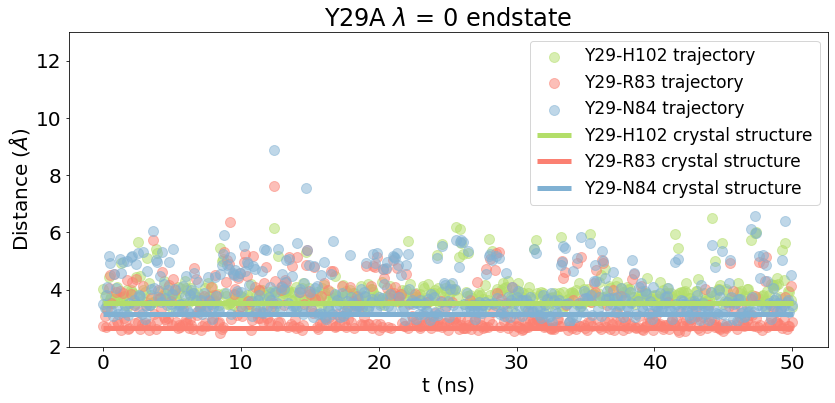

<Figure size 432x288 with 0 Axes>

In [8]:
# Load data
with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_distances_traj_data.pickle", "rb") as f:
    distances_traj_all = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_distances_bsbn_data.pickle", "rb") as f:
    distances_bsbn_all =  pickle.load(f)     

# Create figure
fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(12, 6))

# Set font size
plt.rc('font', size=20) 

# Plot
residue_pair_labels = ["Y29-H102", "Y29-R83", "Y29-N84"]
colors = ["#b3de69", "#fb8072", "#80b1d3"]
for distances_traj, distances_bsbn, residue_pair_label, color in zip(distances_traj_all, distances_bsbn_all, residue_pair_labels, colors):
    plt.scatter(np.arange(len(distances_traj))*100/1000, distances_traj, color=color, s=100, alpha=0.5, label=f"{residue_pair_label} trajectory")
    
for distances_traj, distances_bsbn, residue_pair_label, color in zip(distances_traj_all, distances_bsbn_all, residue_pair_labels, colors):
    plt.hlines(distances_bsbn[0], 0, len(distances_traj)*100/1000, color=color, linewidth=5, label=f"{residue_pair_label} crystal structure")

# Add axis labels    
plt.xlabel("t (ns)")
plt.ylabel("Distance ($\AA$)")

# Add legend
plt.legend(fontsize=17)
    
# Set ylim
plt.ylim([2, 13])
    
# Add title
plt.title(r"Y29A $\lambda$ = 0 endstate")

# Ensure x-axis labels are not cut off
plt.tight_layout()

# Save figure
plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{sub_dir}_{phase}_residue_distances.pdf", dpi=500)

plt.show()
plt.clf()
